In [1]:
import os
import datasets
import transformers
import torch
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [2]:
import pandas as pd


# Load the dataset
train_df_full = pd.read_csv('train.csv')  # Replace with the actual path to your dataset
test_df_full = pd.read_csv('test.csv')    # Replace with the actual path to your dataset

# Take 1% of the training dataset and assign it to train_df
train_df= train_df_full.sample(frac=0.01, random_state=SEED)  # random_state ensures reproducibility

# Take 1% of the test dataset and assign it to test_df
test_df= test_df_full.sample(frac=0.01, random_state=SEED)  # random_state ensures reproducibility

# Display the first few rows
print(train_df.head())

             id    target                                       comment_text  \
458232   806064  0.000000  It's difficult for many old people to keep up ...   
272766   576402  0.166667  She recognized that her tiny-handed husband is...   
339129   658508  0.000000  HPHY76,\nGood for you for thinking out loud, w...   
773565  5066714  0.500000  And I bet that in the day you expected your Je...   
476233   828147  0.000000  Kennedy will add a much needed and scientifica...   

        severe_toxicity  obscene  identity_attack    insult  threat  asian  \
458232              0.0      0.0              0.0  0.000000     0.0    NaN   
272766              0.0      0.0              0.0  0.166667     0.0    NaN   
339129              0.0      0.0              0.0  0.000000     0.0    NaN   
773565              0.0      0.0              0.4  0.100000     0.0    0.0   
476233              0.0      0.0              0.0  0.000000     0.0    NaN   

        atheist  ...  article_id    rating  funny 

In [3]:
# Check the column names
print(train_df.columns)

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')


In [4]:
print(train_df['target'].value_counts())

target
0.000000    12729
0.166667     1421
0.200000     1055
0.300000      551
0.400000      510
            ...  
0.506667        1
0.876923        1
0.148148        1
0.770492        1
0.095238        1
Name: count, Length: 458, dtype: int64


In [5]:
 #Handle missing or invalid values in the 'comment_text' column
train_df['comment_text'] = train_df['comment_text'].fillna('')  # Replace NaN with empty strings
train_df['comment_text'] = train_df['comment_text'].astype(str)  # Ensure all values are strings

# Preprocess the text (example: lowercase and remove special characters)
train_df['comment_text'] = train_df['comment_text'].str.lower().replace(r'[^\w\s]', '', regex=True)

# Apply a threshold of 0.5 to binarize the 'target' column
train_df['target'] = (train_df['target'] >= 0.5).astype(int)

# Check the distribution of the binarized labels
print(train_df['target'].value_counts())

target
0    16677
1     1372
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['comment_text'], train_df['target'], test_size=0.2, random_state=42
)

# Verify the split
print("Training texts:", len(train_texts))
print("Validation texts:", len(val_texts))
print("Training labels distribution:\n", train_labels.value_counts())

Training texts: 14439
Validation texts: 3610
Training labels distribution:
 target
0    13340
1     1099
Name: count, dtype: int64


In [7]:
from datasets import Dataset
from transformers import AutoTokenizer
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Replace with your model ID if different

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels.astype(int)})  # Ensure labels are integers
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels.astype(int)})  # Ensure labels are integers

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], max_length=128, truncation=True, padding='max_length')

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/14439 [00:00<?, ? examples/s]

Map:   0%|          | 0/3610 [00:00<?, ? examples/s]

In [8]:
# Create DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertConfig, BertModel
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm.auto import tqdm

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
val_dataloader = DataLoader(tokenized_val_dataset, batch_size=32, collate_fn=data_collator)

# Define the Teacher Model
teacher_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
teacher_model.to(device)
teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
# Define the Student Model
configuration = teacher_model.config.to_dict()
configuration['num_hidden_layers'] //= 2  # Reduce the number of layers by half
student_config = BertConfig.from_dict(configuration)
student_model = AutoModelForSequenceClassification.from_config(student_config)
student_model.to(device)

# Function to Distill Weights (Odd Layers)
def distill_odd_layers(teacher, student):
    teacher_layers = teacher.bert.encoder.layer  # Access the encoder layers of the teacher
    student_layers = student.bert.encoder.layer  # Access the encoder layers of the student

    for i in range(len(student_layers)):
        # Copy weights from odd layers of the teacher (1, 3, 5, 7, 9, 11)
        student_layers[i].load_state_dict(teacher_layers[2 * i].state_dict())

# Function to Distill Weights (Even Layers)
def distill_even_layers(teacher, student):
    teacher_layers = teacher.bert.encoder.layer  # Access the encoder layers of the teacher
    student_layers = student.bert.encoder.layer  # Access the encoder layers of the student

    for i in range(len(student_layers)):
        # Copy weights from even layers of the teacher (2, 4, 6, 8, 10, 12)
        student_layers[i].load_state_dict(teacher_layers[2 * i + 1].state_dict())

# Distill Weights (Even Layers)

distill_even_layers(teacher_model, student_model)
print("Student model initialized with even layers.")

Student model initialized with even layers.


In [10]:
# Define Loss Functions
criterion_div = nn.KLDivLoss(reduction='batchmean')
criterion_cos = nn.CosineEmbeddingLoss()

In [11]:
# Define Optimizer and Scheduler
optimizer = torch.optim.Adam(student_model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=num_training_steps)

In [12]:
# Lists to store losses for plotting
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []
eval_accuracies = []

# Training Loop
for epoch in range(num_epochs):
    student_model.train()
    teacher_model.eval()
    total_loss = 0
    total_loss_cls = 0
    total_loss_div = 0
    total_loss_cos = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass (Student)
        student_outputs = student_model(**batch)

        # Forward pass (Teacher)
        with torch.no_grad():
            teacher_outputs = teacher_model(**batch)

        # Compute Losses
        loss_cls = student_outputs.loss  # Classification loss
        loss_div = criterion_div(
            torch.log_softmax(student_outputs.logits / 2.0, dim=-1),
            torch.softmax(teacher_outputs.logits / 2.0, dim=-1)
        )  # Distillation loss
        loss_cos = criterion_cos(
            student_outputs.logits, teacher_outputs.logits, torch.ones(batch['input_ids'].size(0)).to(device)
        )  # Cosine loss

        # Total Loss
        loss = (loss_cls + loss_div + loss_cos) / 3
        total_loss += loss.item()
        total_loss_cls += loss_cls.item()
        total_loss_div += loss_div.item()
        total_loss_cos += loss_cos.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    # Store losses for plotting
    train_losses.append(total_loss / len(train_dataloader))
    train_losses_cls.append(total_loss_cls / len(train_dataloader))
    train_losses_div.append(total_loss_div / len(train_dataloader))
    train_losses_cos.append(total_loss_cos / len(train_dataloader))

    # Print training logs
    print(f'Epoch at {epoch + 1}: Train loss {train_losses[-1]:.4f}:')
    print(f'  - Loss_cls: {train_losses_cls[-1]:.4f}')
    print(f'  - Loss_div: {train_losses_div[-1]:.4f}')
    print(f'  - Loss_cos: {train_losses_cos[-1]:.4f}')


Epoch 1/3:   0%|          | 0/452 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1635:
  - Loss_cls: 0.3410
  - Loss_div: 0.0643
  - Loss_cos: 0.0854


Epoch 2/3:   0%|          | 0/452 [00:00<?, ?it/s]

Epoch at 2: Train loss 0.1542:
  - Loss_cls: 0.3200
  - Loss_div: 0.0757
  - Loss_cos: 0.0670


Epoch 3/3:   0%|          | 0/452 [00:00<?, ?it/s]

Epoch at 3: Train loss 0.1411:
  - Loss_cls: 0.2707
  - Loss_div: 0.0893
  - Loss_cos: 0.0635


Epoch at 3: Test Acc 0.9374
Avg Metric 0.6249307479224376


ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

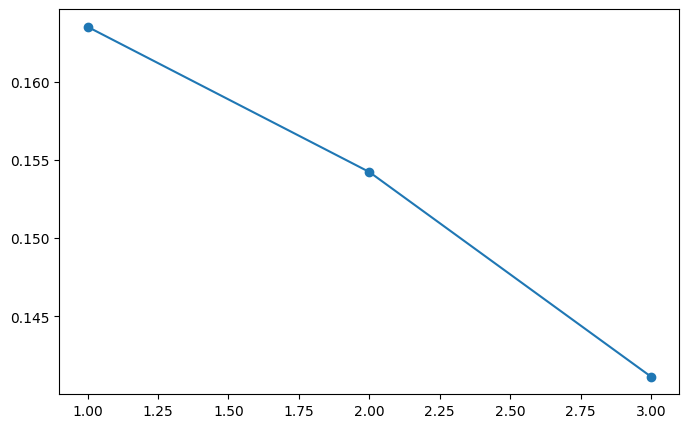

In [14]:
import matplotlib.pyplot as plt
# Evaluation
student_model.eval()
eval_loss = 0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = student_model(**batch)
        loss_cls = outputs.loss
        eval_loss += loss_cls.item()

        predictions = torch.argmax(outputs.logits, dim=-1)
        total_correct += (predictions == batch['labels']).sum().item()
        total_samples += batch['labels'].size(0)

    eval_losses.append(eval_loss / len(val_dataloader))
    eval_accuracy = total_correct / total_samples
    eval_accuracies.append(eval_accuracy)

    # Print evaluation logs
    print(f"Epoch at {epoch + 1}: Test Acc {eval_accuracy:.4f}")

# Print average evaluation metric
print('Avg Metric', sum(eval_accuracies) / num_epochs)

# Plotting
epochs_list = range(1, num_epochs + 1)

# Plot 1: Total Train Loss and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, train_losses, label='Total Train Loss', marker='o')
plt.plot(epochs_list, eval_losses, label='Validation Loss', marker='o')
plt.title('Total Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Train Loss Components (Loss_cls, Loss_div, Loss_cos)
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls', marker='o')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div', marker='o')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos', marker='o')
plt.title('Train Loss Components')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, eval_losses, label='Validation Loss', marker='o', color='red')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()